# P1. Análisis de series de tiempo para base de hurtos en Bogotá

Lupe Pinzón Wagner     Código:200813063  
John Alexander Florez  Código:201920529  
Jorge González García  Código:201920233  
Nestor Fabián Cholo    Código:201523509


## Contexto

Se desea identificar el comportamiento de los hurtos a personas en la ciudad de Bogotá en el año 2018 para comprender la estacionalidad del fenómeno y con base en estos resultados generar políticas y recomendaciones que mejoren los indices de seguridad a los Bogotanos.

In [3]:
#Cargue de librerias
import os
import pandas as pd
import seaborn as sb
import pandas as pd
import numpy as np
from sklearn import preprocessing
import geopandas as gpd
import matplotlib.pyplot as plt


Para generar una lectura inicial del comportamiento de los hurtos en la cuidad se realiza un mapa temático que nos permita identificar las localidades de la ciudad en donde se presentaron el mayor número de hurtos. 

In [25]:
# Cargue capa temática

localidad = "base_dia_semana.json"
map_data = gpd.read_file(localidad)
map_data.head(2)

,FID,OBJECTID,LocNombre,LocCodigo,LOCALIDAD,Domingo,Lunes,Martes,Miercoles,Jueves,Viernes,Sabado,Total,geometry
0,0,1,ANTONIO NARIÑO,15,ANTONIO NARIÑO,223,358,376,409,439,439,451,2695,"POLYGON ((-74.13075 4.59335, -74.13075 4.59335..."
1,1,2,TUNJUELITO,06,TUNJUELITO,304,455,500,491,521,540,444,3255,"POLYGON ((-74.13777 4.59489, -74.14043 4.59536..."


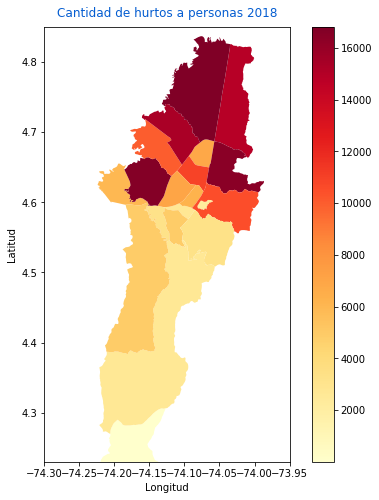

In [26]:
# Control del tamaño de la figura del mapa
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Control del encuadre (área geográfica) del mapa
ax.axis([-74.3, -73.95, 4.23, 4.85])
 
# Control del título y los ejes
ax.set_title('Cantidad de hurtos a personas 2018', 
             pad = 10, 
             fontdict={'fontsize':12, 'color': '#065ed1'})
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Mostrar el mapa finalizado
map_data.plot(column='Total', cmap='YlOrRd', ax=ax,legend=True, zorder=5)

Del analisis exploratorio se concluye que las cinco (5) localidades con el mayor porcentaje de hurtos a personas son:

~  SUBA  
~  KENNEDY  
~  CHAPINERO  
~  ENGATIVA  
~  USAQUEN  

En estas localidades se concentra el 49.5% del total de hurtos en la ciudad.



### Análisis de Series de Tiempo

In [4]:
#Cargue base de datos a analizar

base = pd.read_csv("base_dia.csv", sep= ";",)
base.shape
base.head(4)

,N,FECHA,ANTONIO NARIÑO,BARRIOS UNIDOS,BOSA,CANDELARIA,CHAPINERO,CIUDAD BOLIVAR,ENGATIVA,FONTIBON,...,RAFAEL URIBE URIBE,SAN CRISTOBAL,SANTA FE,SUBA,SUMAPAZ,TEUSAQUILLO,TUNJUELITO,USAQUEN,USME,Total
0,1,1/01/2018,NaN,5.0,7,1.0,6,4.0,9,5,...,6,3.0,2,9,NaN,4,3.0,5,3.0,96
1,2,2/01/2018,9.0,14.0,4,2.0,7,3.0,29,12,...,7,6.0,5,22,NaN,5,3.0,39,2.0,204
2,3,3/01/2018,8.0,8.0,18,5.0,35,3.0,20,13,...,8,7.0,14,29,NaN,17,3.0,32,4.0,275
3,4,4/01/2018,NaN,15.0,9,5.0,20,13.0,38,24,...,14,7.0,10,35,NaN,5,9.0,19,2.0,280


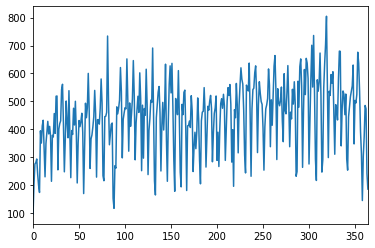

In [5]:
#Construcción data frame con información a analizar

serie = base.loc[:,['FECHA','Total']]
serie['Total'].plot()

Para realizar el análisis primero debemos validar si la serie de datos es estacional, es decir que cumpla con las siguientes condiciones:  

~ La media no dependa del tiempo  
~ La varianza no dependa del tiempo  
~ La autocorrelacion no dependa del tiempo 

Aparentemente, según el grafico de tendencia, la serie es estacionaria. Para asegurarnos de esta conclusión usamos la prueba de Dickey Fuller.

In [29]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(serie['Total'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.375024
p-value: 0.011840
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


Con el resultado de la prueba (p-vaue = 0.011) podemos afirmar que la serie de tiempo de hurtos en Bogotá para el año 2018 es estacional. A continuación analizaremos las gráficas de autocorrelación para entender los componentes de autoregresión y promedio móvil.

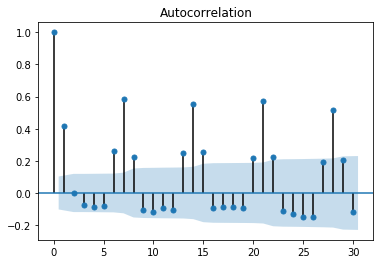

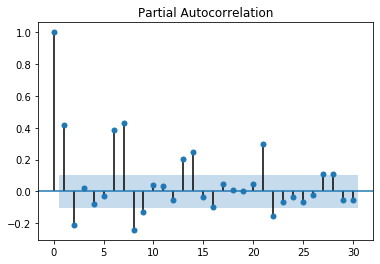

In [30]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(serie['Total'], lags=30);
plot_pacf(serie['Total'], lags=30);

De la grafica de autocorrelación podemos concluir que hay proceso estacional con periodicidad de 7 dias, el cual puede estar asociado a los fines de semana.

Con un intervalo del 95% se podria decir de igual manera que  existen 11 autocorrelaciones significativas.

La grafica de autocorrelacion nos permite evidenciar que el periodo 1 es el que más esta afectando la serie y con una menor significancia los periodos 2, 7 y 8.

# ARIMA


A continuación usaremos el modelo ARIMA para realizar un pronostico de la serie para el siguiente mes.

Los parametros fueron seleccionados a través de la función auto_arima que evalúa diferentes parámetros y selecciona los que mejor se ajustan al modelo, finalmente se seleccionó (0,0,1) con un AIC de 4491.18

También se evaluó iterando diferentes combinaciones de acuerdo con el análisis gráfico y se seleccionó (4,0,6) que daba un AIC de 4291.374, sin embargo, la media de los errores estaba más alejada de cero y la varianza no era constante, por lo que se decidió usar el primer método.

In [21]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(serie.Total, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=12, max_q=12, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=4491.803, BIC=4507.403, Time=0.651 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=4573.862, BIC=4581.662, Time=0.021 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=4504.986, BIC=4516.685, Time=0.048 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=4491.182, BIC=4502.882, Time=0.304 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=5515.480, BIC=5519.380, Time=0.019 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=4491.400, BIC=4507.000, Time=0.283 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=4494.218, BIC=4513.717, Time=0.494 seconds
Total fit time: 1.960 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -2242.591
Date:                Sun, 21 Jun 2020   AIC  

In [22]:
from statsmodels.tsa.arima_model import ARIMA

model_arima = ARIMA(serie['Total'], order=(0,0,1))
model_fit = model_arima.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Total   No. Observations:                  365
Model:                     ARMA(0, 1)   Log Likelihood               -2242.591
Method:                       css-mle   S.D. of innovations            112.706
Date:                Sun, 21 Jun 2020   AIC                           4491.182
Time:                        22:46:54   BIC                           4502.882
Sample:                             0   HQIC                          4495.832
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         442.8979      8.754     50.594      0.000     425.741     460.055
ma.L1.Total     0.4852      0.043     11.302      0.000       0.401       0.569
                                    Roots       

El modelo generó un parámetro significativo al igual que la constante. La ecuación que mejor describe el modelo es

**X(t) = 442.89 + 0.49 * x(t-1)**

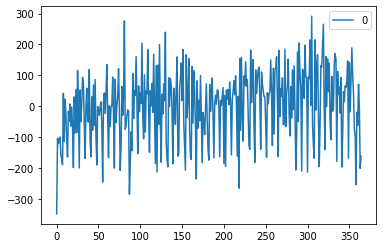

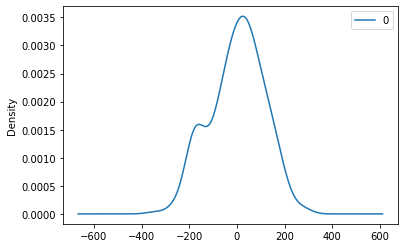

                0
count  365.000000
mean     0.164502
std    113.146617
min   -346.897893
25%    -66.959138
50%      7.461374
75%     82.405780
max    291.182529


In [23]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

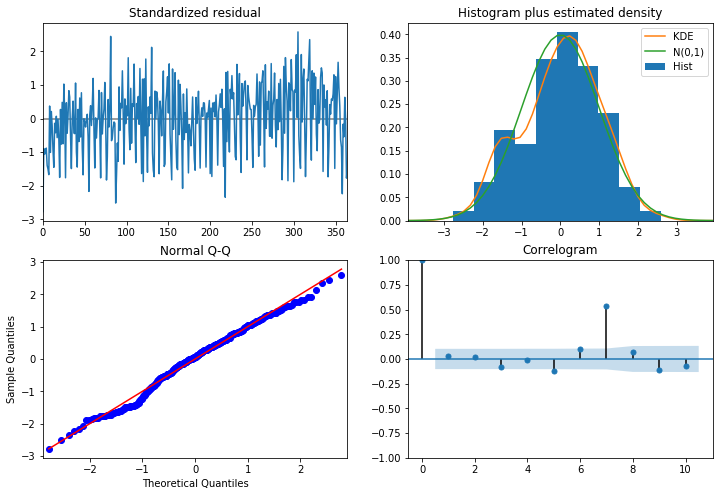

In [24]:
import matplotlib.pyplot as plt
model.plot_diagnostics(figsize=(12,8))
plt.show()

**Gráfica errores estandarizados:** los errores fluctuan alrededor de la media y la varianza es constante. 

**Histograma:** muestra que los valores estan centrados en cero (0) y tienen formal de distribución "normal".

**Normal Q-Q:** los puntos azules coninciden con la línea roja por tanto la distribución no esta sesgada.

**Correlograma:** muestra que los residuales no se encuentran autocorrelacionados. se confirma que el proceso es estacional con periodicidad de 7 dias, el cual esta asociado con el comportamiento de los hurtos los fines de semana.

# Rolling Forecast ARIMA

In [31]:
X = serie['Total'].values
size = int(len(X) * 0.90)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
interval_low = []
interval_hight = []

 

for t in range(len(test)):
    model = ARIMA(history, order=(0,0,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    interval_low.append(output[2][0][0])
    interval_hight.append(output[2][0][1])
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=418.009275, expected=310.000000
predicted=389.741681, expected=488.000000
predicted=488.576130, expected=475.000000
predicted=435.163474, expected=433.000000
predicted=440.584676, expected=579.000000
predicted=508.362810, expected=680.000000
predicted=525.394546, expected=679.000000
predicted=517.869863, expected=340.000000
predicted=357.420753, expected=470.000000
predicted=496.651007, expected=537.000000
predicted=462.711814, expected=525.000000
predicted=473.572124, expected=452.000000
predicted=433.440883, expected=526.000000
predicted=488.216900, expected=293.000000
predicted=351.213276, expected=253.000000
predicted=396.524429, expected=444.000000
predicted=465.714546, expected=481.000000
predicted=450.429284, expected=516.000000
predicted=474.696749, expected=536.000000
predicted=472.941058, expected=555.000000
predicted=483.248652, expected=630.000000
predicted=514.975780, expected=347.000000
predicted=364.049484, expected=503.000000
predicted=509.567958, expected=494

In [32]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test, predictions)**0.5
print('Test MSE: %.3f' % error)

Test MSE: 116.075


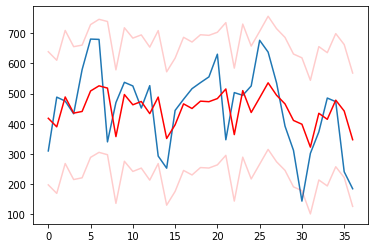

In [33]:
from statsmodels.graphics.tsaplots import plot_acf
plt.plot(test)
plt.plot(predictions, color='red')
plt.plot(interval_low, color='red', alpha = 0.2)
plt.plot(interval_hight, color='red' , alpha = 0.2)
plt.show()

En la gráfica se puede observar que la observación 30, esta por fuera del intervalo de confianza del pronostico.

El MSE del modelo es de 116.08 que comparado con la última predicción que es de 347.16, es de 33.4%. Al revisar la gráfica de las predicciones vs el Test, se puede ver que solamente la predicción del día 30 se sale del intervalo de confianza (95%).

## Prophet

A continuación usaremos Prophet para realizar un pronóstico de la serie para el siguiente mes:

In [6]:
#ajustar la serie a la estructura requerida por prophet
serie.rename(columns={'FECHA':'ds','Total':'y'}, inplace=True)
serie['ds'] = pd.to_datetime(serie['ds'])

In [7]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

m = Prophet()
m.fit(serie)

#Haremos el pronostico de los próximos 30 días.
future = m.make_future_dataframe(periods=30, freq='D')
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
365,2019-01-01,474.005601,330.908311,609.031769
366,2019-01-02,504.280329,352.368839,651.891907
367,2019-01-03,521.626919,371.627451,673.557307
368,2019-01-04,541.051241,406.508382,687.030655
369,2019-01-05,498.816900,349.496556,641.272846
370,2019-01-06,363.969510,231.756901,511.571011
371,2019-01-07,464.836253,317.713984,608.953671
372,2019-01-08,475.433276,339.001438,612.817394
373,2019-01-09,505.708003,359.484046,646.281495
374,2019-01-10,523.054594,376.862646,663.474024


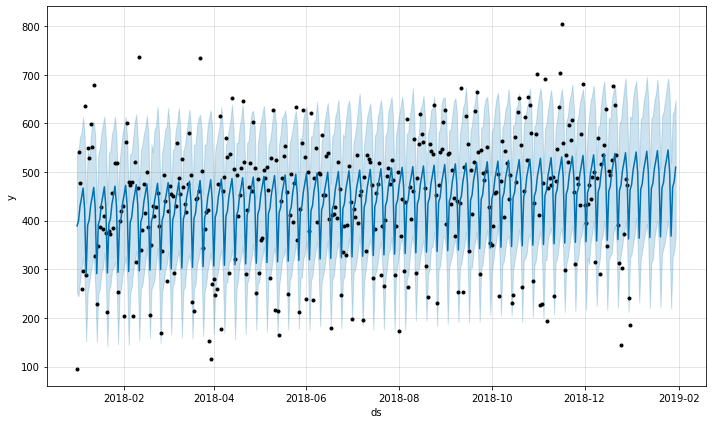

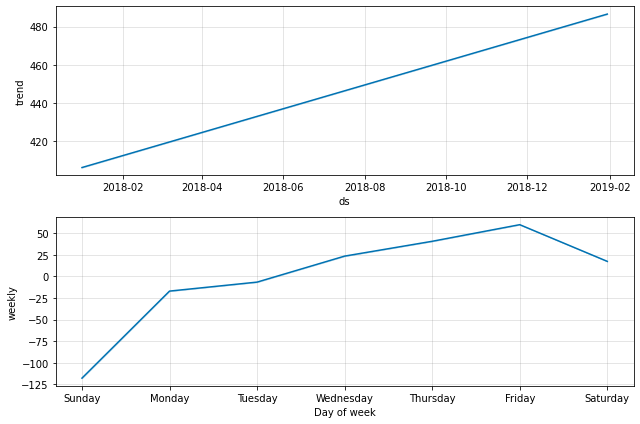

In [8]:
fig1 = m.plot(forecast)
m.plot_components(forecast);

En la primera gráfica podemos ver que las observaciones reales estan bastante dispersas y en algunos casos lejanas a la linea que muestra como se esta ajustando el modelo.

De las siguientes gráficas se debe resaltar que prophet identifica que los viernes son el día de la semana con mayor numero de hurtos.

## Rolling Forecast Prophet  

Usando prophet se hará el rolling forecast del 10% de la serie.

In [9]:
#Creación de los pronosticos
size = int(len(serie) * 0.90)
train, test = serie[0:size], serie[size:len(serie)]
predictions = pd.DataFrame()

for t in range(len(test)):
    future = m.make_future_dataframe(periods=1, freq='M')
    forecast = m.predict(future)
    predictions[t]=forecast.iloc[len(train)+t]
    resultado = predictions.T[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [10]:
#Inlcuir las observaciones reales para calcular el MSE
for x in range(0,37):
    resultado.loc[x,'obs']= test.loc[len(train)+x,'y']
resultado

,ds,yhat,yhat_lower,yhat_upper,obs
0,2018-11-25 00:00:00,355.403,214.258,512.22,310.0
1,2018-11-26 00:00:00,456.27,310.407,601.382,488.0
2,2018-11-27 00:00:00,466.867,324.167,607.378,475.0
3,2018-11-28 00:00:00,497.142,353.276,638.176,433.0
4,2018-11-29 00:00:00,514.489,372.386,662.142,579.0
5,2018-11-30 00:00:00,533.913,388.912,688.038,680.0
6,2018-12-01 00:00:00,491.679,352.788,638.711,679.0
7,2018-12-02 00:00:00,356.831,221.686,503.158,340.0
8,2018-12-03 00:00:00,457.698,306.14,593.181,470.0
9,2018-12-04 00:00:00,468.295,318.498,606.979,537.0


In [11]:
from sklearn.metrics import mean_squared_error
error_rolling_prophet = mean_squared_error(resultado['obs'], resultado['yhat'])**0.5
print('Test MSE: %.3f' % error_rolling_prophet)

Test MSE: 113.538


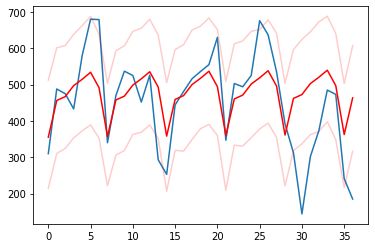

In [14]:
plt.plot(resultado['obs'])
plt.plot(resultado['yhat'], color='red')
plt.plot(resultado['yhat_lower'], color='red',alpha = 0.2)
plt.plot(resultado['yhat_upper'], color='red',alpha = 0.2)
plt.show()

El error para las predicciones es de 113.53 lo que representa un 24,5% comparando con la ultima predicción, mejorando el desempeño del rolling forecast con ARIMA que tenia un error cercano al 33%. Las observaciones 6,13,24,30 y 36 se encuentran por fuera del intervalo de confianza definido por el modelo.

## Conclusiones  

1. Con el modelo generado con prophet tenemos un MSE 113.53 y con el modelo generado con ARIMA tenemos un MSE de 116.08, comparando dichos errores con la ultma predicción, en proporción es mas pequeño el error con prophet(9 puntos por debajo). Prophet identifica la estacionalidad semanal, donde aumenta el numero de hurtos desde el domingo y tiene un pico el día viernes, basado en esa estacionalidad realiza las predicciónes. Por lo anterior el modelo que mejor se ajusta es el Prophet.


2. Aunque en el análisis gráfico de las autocorrelaciones, muestra una correlación cada 7 días, cuando probamos los parámetros del modelo ARIMA, de forma manual encontramos que el mejor AIC se obtiene dejando como parámetro de autorregresiones 4 y de promedio movil 6, sin embargo, con este modelo, la media de los errores no era tan cercana a 0. Por lo anterior, probamos usando la función "auto_arima" que arrojó los parámetros (0,0,1), obteniendo como resultado una media de los errores de 0.16.


3. Dada la distribución de los datos no fue necerio aplicar diferenciación o transformación de los mismos, se usó la base sin ajustes, ya que existe una estacionalidad cada 7 días, con picos en los robos los días viernes.


4. Se recomienda realizar un fortalecimiento de la seguridad de jueves a sábado, especialmente los días viernes donde se espera que se superen los 540 hurtos en la ciudad de Bogotá, con especial atención en las localidades SUBA, KENNEDY, CHAPINERO, ENGATIVA y USAQUEN.